In [1]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as transforms
import numpy as np
from sklearn import preprocessing

import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import operator

import time
from torch.optim import lr_scheduler

In [2]:
img_width = 256
img_height = 128
img_channel = 3
label_width = 256
label_height = 128
label_channel = 1
class_num = 2 

data_loader_numworkers = 8

train_path = "/kaggle/input/trainset/trainset/train_index.txt"
val_path = "/kaggle/input/trainset/trainset/val_index.txt"
test_path = "/kaggle/input/trainset/testset/test_index.txt"
save_path = "/kaggle/working/"
pretrained_path = "/kaggle/input/segnet/95.6911901950295.pth"

class_weight = [0.02, 1.02]

seed = 69
batch_size = 15
test_batch_size = 1
lr = 0.01
epochs = 10
log_interval = 300

In [3]:
def readTxt(file_path):
	img_list = []
	with open(file_path, 'r') as file_to_read:
		while True:
			lines = file_to_read.readline()
			if not lines:
				break
			item = lines.strip().split()
			img_list.append(item)
	file_to_read.close()
	for i in range(len(img_list)):
		for j in range(len(img_list[i])):
			img_list[i][j] = img_list[i][j].replace("D:/dataset","/kaggle/input/trainset/trainset")
	return img_list

class RoadSequenceDataset(Dataset):

	def __init__(self, file_path, transforms):
		self.img_list = readTxt(file_path)
		self.dataset_size = len(self.img_list)
		self.transforms = transforms

	def __len__(self):
		return self.dataset_size

	def __getitem__(self, idx):
		img_path_list = self.img_list[idx]
		data = Image.open(img_path_list[4])
		label = Image.open(img_path_list[5])
		data = self.transforms(data)
		label = torch.squeeze(self.transforms(label))
		sample = {'data':data, 'label':label}
		return sample

In [4]:
torch.manual_seed( seed )
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu" )
op_transforms = transforms.Compose([transforms.ToTensor()])
device

device(type='cuda')

In [5]:
train_loader = torch.utils.data.DataLoader(
	RoadSequenceDataset(
		file_path  = train_path,
		transforms = op_transforms),
		batch_size = batch_size,
		shuffle = True,
		num_workers = data_loader_numworkers
	)

In [6]:
val_loader = torch.utils.data.DataLoader(
	RoadSequenceDataset(
		file_path  = val_path,
		transforms = op_transforms),
		batch_size = test_batch_size,
		shuffle = True,
		num_workers = data_loader_numworkers
	)

In [7]:
def generate_model():
	use_cuda = torch.cuda.is_available()
	device = torch.device("cuda" if use_cuda else "cpu" )
	return SegNet().to(device)

class SegNet(nn.Module):
	def __init__(self):
		super(SegNet,self).__init__()
		self.vgg16_bn = models.vgg16_bn().features
		self.relu = nn.ReLU(inplace=True)
		self.index_MaxPool = nn.MaxPool2d(
			kernel_size=2, stride=2, return_indices=True)
		self.index_UnPool = nn.MaxUnpool2d(
			kernel_size=2, stride=2)
		global class_num

		self.conv1_block = nn.Sequential( self.vgg16_bn[0],
										self.vgg16_bn[1],
										self.vgg16_bn[2],
										self.vgg16_bn[3],
										self.vgg16_bn[4],
										self.vgg16_bn[5]
										)
		self.conv2_block = nn.Sequential( self.vgg16_bn[7],
										self.vgg16_bn[8],
										self.vgg16_bn[9],
										self.vgg16_bn[10],
										self.vgg16_bn[11],
										self.vgg16_bn[12]
										)
		self.conv3_block = nn.Sequential( self.vgg16_bn[14],
										self.vgg16_bn[15],
										self.vgg16_bn[16],
										self.vgg16_bn[17],
										self.vgg16_bn[18],
										self.vgg16_bn[19],
										self.vgg16_bn[20],
										self.vgg16_bn[21],
										self.vgg16_bn[22]
										)
		self.conv4_block = nn.Sequential( self.vgg16_bn[24],
										self.vgg16_bn[25],
										self.vgg16_bn[26],
										self.vgg16_bn[27],
										self.vgg16_bn[28],
										self.vgg16_bn[29],
										self.vgg16_bn[30],
										self.vgg16_bn[31],
										self.vgg16_bn[32]
										)
		self.conv5_block = nn.Sequential( self.vgg16_bn[34],
										self.vgg16_bn[35],
										self.vgg16_bn[36],
										self.vgg16_bn[37],
										self.vgg16_bn[38],
										self.vgg16_bn[39],
										self.vgg16_bn[40],
										self.vgg16_bn[41],
										self.vgg16_bn[42]
										)
		self.upconv5_block = nn.Sequential(
			nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			)
		self.upconv4_block = nn.Sequential(
			nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(512, 256, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			)
		self.upconv3_block = nn.Sequential(
			nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(256, 128, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			)
		self.upconv2_block = nn.Sequential(
			nn.Conv2d(128, 128, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			)
		self.upconv1_block = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=(3,3), padding=(1,1)),
			nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
			self.relu,
			nn.Conv2d(64, class_num, kernel_size=(3,3), padding=(1,1)),
			)

	def forward(self, x):
		f1, idx1 = self.index_MaxPool(self.conv1_block(x))
		f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
		f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
		f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
		f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
		up6 = self.index_UnPool( f5, idx5 ) 
		up5 = self.index_UnPool( self.upconv5_block(up6), idx4 )
		up4 = self.index_UnPool( self.upconv4_block(up5), idx3 )
		up3 = self.index_UnPool( self.upconv3_block(up4), idx2 )
		up2 = self.index_UnPool( self.upconv2_block(up3), idx1 )
		up1 = self.upconv1_block(up2)

		return F.log_softmax( up1, dim=1)

In [8]:
SegNet()

SegNet(
  (vgg16_bn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 

In [9]:
def train( epoch, model, train_loader, device, optimizer, criterion ):
	since = time.time()
	global log_interval
	model.train()
	for batch_idx, sample_batched in enumerate(train_loader):
		data = sample_batched['data'].to(device)
		target = sample_batched['label'].type(torch.LongTensor).to(device)
		optimizer.zero_grad()
		output = model(data)
		loss = criterion( output, target )
		loss.backward()
		optimizer.step()
		if batch_idx % log_interval == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
	time_elapsed = time.time() - since
	print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

In [10]:
def val(model, val_loader, device, criterion, best_acc):
  model.eval()
  test_loss=0
  correct=0
  global test_batch_size
  global label_height
  global label_width
  with torch.no_grad():
    for sample_batched in val_loader:
      data = sample_batched['data'].to(device)
      target = sample_batched['label'].type(torch.LongTensor).to(device)
      output = model(data)
      test_loss += criterion(output,target).item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= (len(val_loader)/test_batch_size)
    val_acc = 100. * int(correct) / (len(val_loader.dataset)*label_width*label_height)
    print('\nAverage loss:{:.4f}, Accuracy:{}/{} ({:.5f}%\n'.format(
        test_loss, int(correct), len(val_loader.dataset), val_acc
    ))
    torch.save(model.state_dict(),'%s.pth'%val_acc)

In [11]:
model = generate_model()
optimizer = torch.optim.Adam(model.parameters(), lr=lr )
scheduler = lr_scheduler.StepLR( optimizer, step_size=1, gamma=0.5)
class_weight = torch.Tensor(class_weight)
criterion = torch.nn.CrossEntropyLoss(weight=class_weight).to(device)
best_acc = 0

In [ ]:
for epoch in range(epochs):
	scheduler.step()
	train(epoch, model, train_loader, device, optimizer, criterion )
	val(model, val_loader, device, criterion, best_acc )

In [29]:
def readTxtTest(file_path):
	img_list = []
	with open(file_path, 'r') as file_to_read:
		while True:
			lines = file_to_read.readline()
			if not lines:
				break
			item = lines.strip().split()
			img_list.append(item)
	file_to_read.close()
	for i in range(len(img_list)):
		for j in range(len(img_list[i])):
			img_list[i][j] = img_list[i][j].replace("D:/dataset","/kaggle/input/trainset/testset")
	return img_list

class RoadSequenceDatasetTest(Dataset):

	def __init__(self, file_path, transforms):
		self.img_list = readTxtTest(file_path)
		self.dataset_size = len(self.img_list)
		self.transforms = transforms

	def __len__(self):
		return self.dataset_size

	def __getitem__(self, idx):
		img_path_list = self.img_list[idx]
		data = Image.open(img_path_list[0])
		label = Image.open(img_path_list[1])
		data = self.transforms(data)
		label = torch.squeeze(self.transforms(label))
		sample = {'data':data, 'label':label}
		return sample

In [30]:
test_loader = torch.utils.data.DataLoader(
	RoadSequenceDatasetTest(
		file_path  = test_path,
		transforms = op_transforms),
		batch_size = test_batch_size,
		shuffle = True,
		num_workers = data_loader_numworkers
	)

In [24]:
pretrained_dict = torch.load(pretrained_path)
model_dict = model.state_dict()
pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
model_dict.update(pretrained_dict_1)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [31]:
def output_result(model, test_loader, device):
    model.eval()
    k = 0
    feature_dic=[]
    with torch.no_grad():
        for sample_batched in test_loader:
            k+=1
            data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            img = torch.squeeze(pred).cpu().unsqueeze(2).expand(-1,-1,3).numpy()*255
            img = Image.fromarray(img.astype(np.uint8))
            data = torch.squeeze(data).cpu().numpy()
            data = np.transpose(data, [1,2,0]) * 255
            data = Image.fromarray(data.astype(np.uint8))
            org = data.copy()
            rows = img.size[0]
            cols = img.size[1]
            for i in range(0, rows):
                for j in range(0, cols):
                    img2 = (img.getpixel((i, j)))
                    if (img2[0] > 200 or img2[1] > 200 or img2[2] > 200):
                        data.putpixel((i, j), (234, 53, 57, 255))
            data = data.convert("RGB")
            org = org.convert("RGB")
            display(org, data)
            if k > 10:
                break
#             data.save(save_path + "%s_data.jpg" % k)#red line on the original image
#             img.save(save_path + "%s_pred.jpg" % k)#prediction result

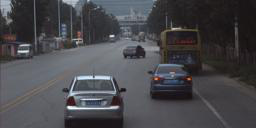

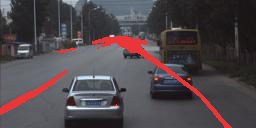

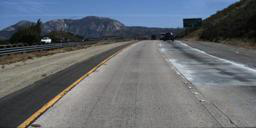

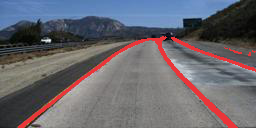

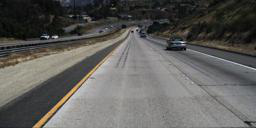

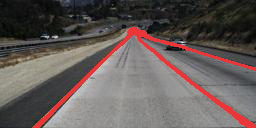

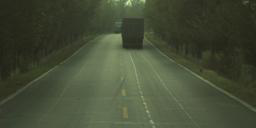

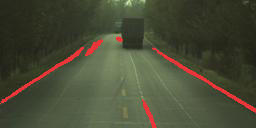

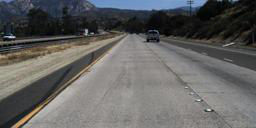

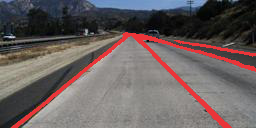

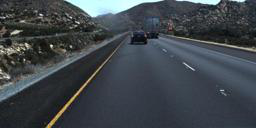

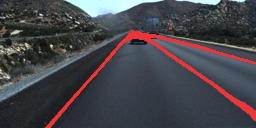

In [32]:
output_result(model, test_loader, device)
# val(model, test_loader, device, criterion, best_acc )